In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
from collections import deque
import os

In [2]:
def get_pricing(csv = '../data/INFY.csv'):
    df = pd.read_csv(csv, index_col = 'Date')
    cl = pd.DataFrame(df['Close'])
    cl['logClose'] = np.log(cl['Close'])
    cl['diffLogClose'] = cl['logClose'] - cl['logClose'].shift(1)
    cl['pctChange'] = cl['Close'].pct_change()
    cl = cl.dropna()
    return cl

In [3]:
def generate_arma(n=1000, ar_coeff=[0.6,], ma_coeff=[0.3,]):

    p = len(ar_coeff)
    q = len(ma_coeff)
    for i in range(q,n):
        x[i] += w[i]
        for j in range(q):
            x[i] += w[i-j-1]*ma_coeff[j]
    for i in range(p,n):
        for j in range(p):
            x[i] += x[i-j-1]*ar_coeff[j]
    return x

In [4]:
def generate_arma(n, ar_coeff=[0.6,], ma_coeff=[0.3,]):
    #this function appends 1 to ar and ma coeff. negates ar coeff
    #calls arma_generate_sample method.
    ar = np.r_[1, -np.array(ar_coeff)]
    ma = np.r_[1, np.array(ma_coeff)]
    print("generating ARMA(%d,%d)"%(len(ar_coeff), len(ma_coeff)))
    return arma_generate_sample(ar, ma, n)

In [5]:
# model = arma_generate_sample(ar=[1,0.5], ma=[1,-0.5], nsample=1000)
model1 = generate_arma(n=1000,ar_coeff=[0.5, -0.25], ma_coeff=[0.5, -0.3])

generating ARMA(2,2)


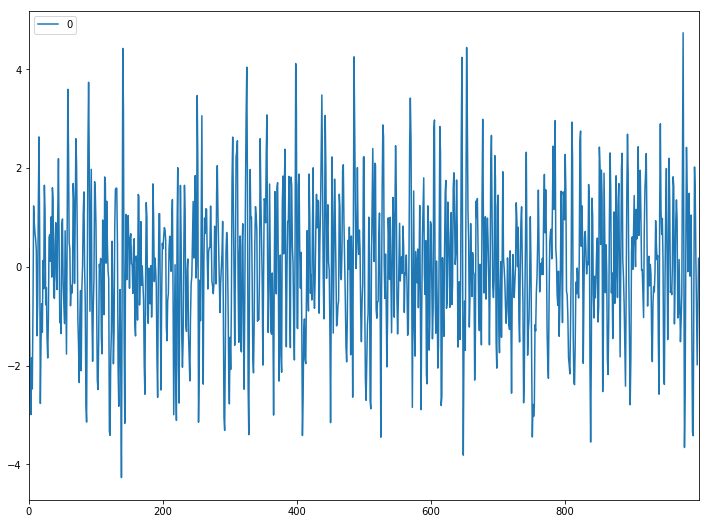

In [6]:
# pd.DataFrame(model).plot(figsize=(12,9))
pd.DataFrame(model1).plot(figsize=(12,9))

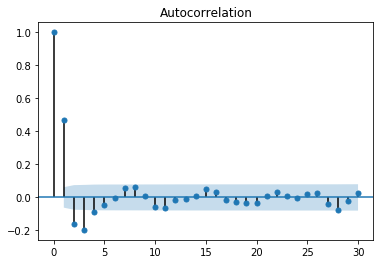

In [7]:
# plot_pacf(model, lags=30)
# plt.show()
plot_acf(model1, lags=30)
plt.show()


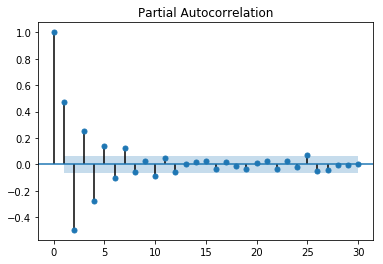

In [8]:
plot_pacf(model1, lags=30)
plt.show()

In [9]:
def test_arma(values, p=1,q=1):
    tmodel = ARMA(endog=values, order = (p,q))
    #We cannot use ARMA(values ) because we need to check order for every q to test.
    mf = tmodel.fit()
    print(mf.summary())
    print("k_ma = ", mf.k_ma)
    print("k_ar = ", mf.k_ar)
    print("coeff = ",mf.params)
    print("Conf Int \n",mf.conf_int())
    return mf

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(2, 2)   Log Likelihood               -1421.833
Method:                       css-mle   S.D. of innovations              1.002
Date:                Thu, 23 May 2019   AIC                           2855.666
Time:                        20:30:08   BIC                           2885.113
Sample:                             0   HQIC                          2866.858
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.049      0.026      0.979      -0.094       0.096
ar.L1.y        0.5517      0.145      3.798      0.000       0.267       0.836
ar.L2.y       -0.2698      0.034     -8.001      0.0

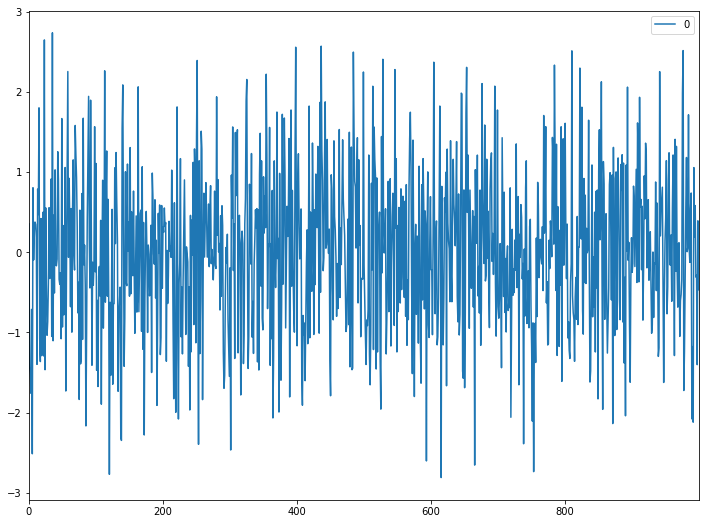

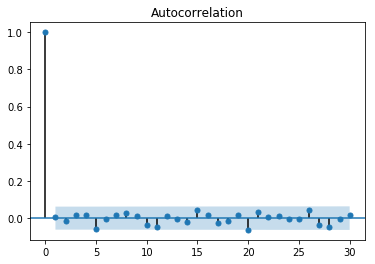

In [10]:
# test_ma_q(model, p=2,q=2)
mf = test_arma(model1, p=2,q=2)
pd.DataFrame(mf.resid).plot(figsize=(12,9))
plot_acf(mf.resid, lags=30)
plt.show()
#acf of residual series must be white noise

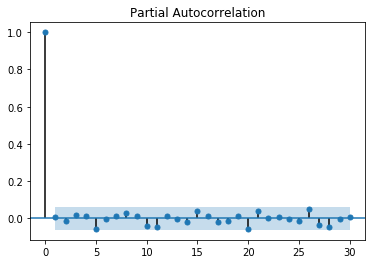

In [11]:
plot_pacf(mf.resid, lags=30)
plt.show()

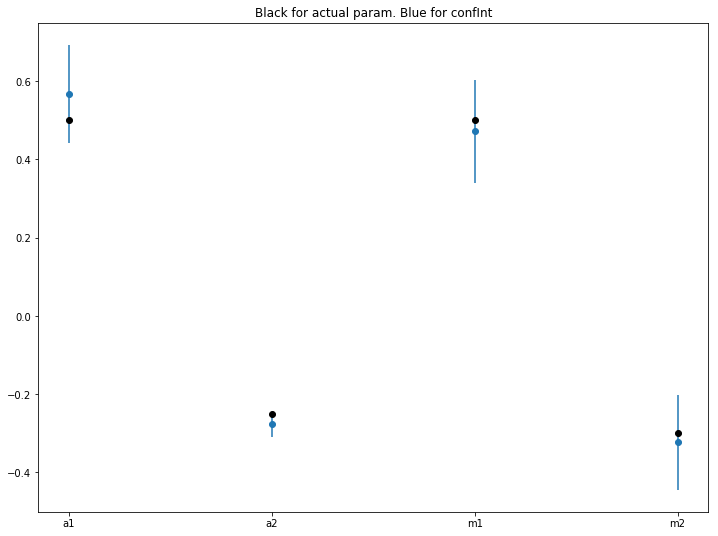

In [12]:
x = ['a1','a2','m1','m2']
y = [0.5665, -0.2774, 0.4712, -0.3226]
yerr = [0.126, 0.033, 0.131, 0.121]
plt.figure(figsize=(12,9))
plt.errorbar(x, y,yerr=yerr ,fmt='o')
plt.plot(x, [0.5, -0.25, 0.5, -0.3], 'ko')
#[np.array(yerr)*(-1.96), np.array(yerr)*1.96] ,
plt.title("Black for actual param. Blue for confInt")
plt.show()

In [20]:
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import display
def determine_arma_order(values):
    plt.plot(values)
    finalmodel = None
    finalorder = (0,0)
    finalaic = np.inf
    for p,q in product(list(range(4)), list(range(4))):
        print("testing for (%d, %d)"%(p,q))
        try:
            test = ARMA(endog=values, order=(p,q))
            tf = test.fit()
            aic = tf.aic
            if aic < finalaic:
                finalaic = aic
                finalorder = (p,q)
                finalmodel = test
        except:
            pass
            print("Cannot fit for (%d, %d)"%(p,q))
    print("final order, AIC: ", finalorder, finalaic)
    finalmodel = ARMA(endog=values, order=finalorder)
    resid = finalmodel.fit(ic='aic').resid
    #Ljung-box test to determine whether ARMA(p,q) is a good fit
    plot_acf(resid, lags=30)
    lbxresid = acorr_ljungbox(resid, lags=20)
    df = pd.DataFrame()
    df['test-Stat Q value'] = lbxresid[0]
    df['p-value'] = lbxresid[1]
    df['reject'] = df['p-value']<=0.05
    display(df)
    return finalorder

generating ARMA(1,0)
testing for (0, 0)
testing for (0, 1)
testing for (0, 2)
testing for (0, 3)
testing for (1, 0)
testing for (1, 1)


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:961: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:964: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:970: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

testing for (1, 2)
testing for (1, 3)
testing for (2, 0)
testing for (2, 1)
testing for (2, 2)
testing for (2, 3)
testing for (3, 0)
testing for (3, 1)
testing for (3, 2)
testing for (3, 3)
final order, AIC:  (3, 2) 2824.204367738562


test-Stat Q value   p-value  reject
0            0.055198  0.814254   False
1            0.118866  0.942299   False
2            0.259927  0.967380   False
3            0.261368  0.992170   False
4            0.261944  0.998298   False
5            1.752532  0.940994   False
6            4.449770  0.726757   False
7            5.727117  0.677768   False
8            5.741436  0.765492   False
9            6.716996  0.751865   False
10           7.270870  0.776743   False
11           7.408885  0.829453   False
12           7.410159  0.879796   False
13           7.797920  0.899586   False
14           8.050127  0.921757   False
15           8.106236  0.945641   False
16           8.125441  0.963790   False
17           8.332423  0.973266   False
18           8.365887  0.982595   False
19           8.821969  0.984879   False

(3, 2)

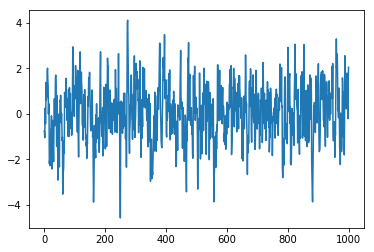

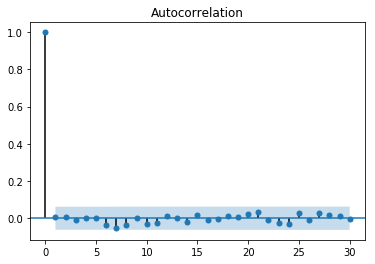

In [21]:
# values = generate_arma(n=1000, ar_coeff=[0.5, -0.25, -0.4], ma_coeff=[0.5, -0.3])
# values = np.diff(np.log(pd.read_csv('../data/INFY.csv')['Close']))
values = generate_arma(1000, ar_coeff=[0.6], ma_coeff=[])
determine_arma_order(values)

testing for (0, 0)
testing for (0, 1)
testing for (0, 2)
testing for (0, 3)
testing for (1, 0)
testing for (1, 1)


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:961: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:964: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:970: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

testing for (1, 2)
testing for (1, 3)
testing for (2, 0)
testing for (2, 1)
testing for (2, 2)
testing for (2, 3)
testing for (3, 0)
testing for (3, 1)
testing for (3, 2)
testing for (3, 3)
final order, AIC:  (2, 0) -14017.438034593331


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


test-Stat Q value   p-value  reject
0            0.004261  0.947953   False
1            0.005780  0.997114   False
2            0.787387  0.852481   False
3            0.818576  0.935940   False
4            0.818576  0.975833   False
5            1.146501  0.979445   False
6            2.058091  0.956555   False
7            2.282300  0.971111   False
8            2.285526  0.986107   False
9            3.020599  0.980935   False
10           5.476245  0.905931   False
11           5.477402  0.940107   False
12           6.053104  0.944199   False
13           6.305022  0.958208   False
14           6.329665  0.973662   False
15           6.582202  0.980499   False
16           6.726460  0.986822   False
17           7.917553  0.979839   False
18           8.071067  0.985941   False
19           8.127782  0.990988   False

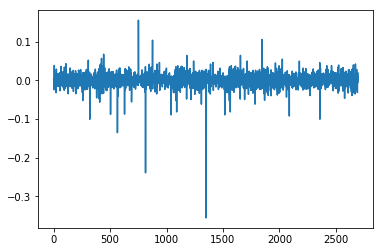

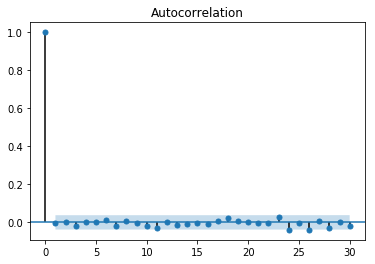

In [22]:
cl = get_pricing('../data/INFY.csv')
order = determine_arma_order(cl['diffLogClose'].values)
model = ARMA(endog=cl['diffLogClose'].values, order=order)